# Analisi della Distribuzione dei Landmark

Questo notebook è dedicato all'analisi della distribuzione dei landmark estratti dal dataset. L'obiettivo principale è comprendere i pattern spaziali e temporali dei landmark, fondamentali per compiti come il riconoscimento delle emozioni e l'analisi dei gesti. Attraverso la visualizzazione e l'interpretazione della distribuzione, miriamo a identificare potenziali anomalie, tendenze e informazioni utili per migliorare le prestazioni dei modelli di machine learning.

### Obiettivi Principali:

- Caricare e preprocessare i dati dei landmark.
- Visualizzare la distribuzione dei landmark nelle diverse dimensioni.
- Analizzare pattern e anomalie nei dati.
- Fornire insight per migliorare i task downstream come l'addestramento e la valutazione dei modelli.

Questa analisi rappresenta un passaggio cruciale per garantire la qualità e l'affidabilità dei dati utilizzati nel progetto EmoSign.


In [3]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import sys

# Aggiungi il percorso radice del progetto per importare le utilità
# os.getcwd() in un notebook è la directory del notebook, quindi dirname ci dà la radice del progetto
BASE_DIR = os.path.dirname(os.getcwd())
if BASE_DIR not in sys.path:
    sys.path.insert(0, BASE_DIR)

from src.utils.training_utils import get_data_paths

# Stile per i grafici
sns.set_style("whitegrid")

## 1. Definizione dei Percorsi dei Dati

Recuperiamo i percorsi delle directory contenenti i landmark di training e validazione utilizzando la funzione di utilità `get_data_paths`.


In [5]:
(
    TRAIN_LANDMARKS_DIR,
    _,
    VAL_LANDMARKS_DIR,
    _,
) = get_data_paths(BASE_DIR)

print(f"Directory dei landmark di training: {TRAIN_LANDMARKS_DIR}")
print(f"Directory dei landmark di validazione: {VAL_LANDMARKS_DIR}")

Directory dei landmark di training: ['/Users/ignazioemanuelepicciche/Documents/TESI Magistrale UCBM/Improved_EmoSign_Thesis/data/raw/train/openpose_output_train/json', '/Users/ignazioemanuelepicciche/Documents/TESI Magistrale UCBM/Improved_EmoSign_Thesis/data/raw/ASLLRP/mediapipe_output_0.34/json']
Directory dei landmark di validazione: /Users/ignazioemanuelepicciche/Documents/TESI Magistrale UCBM/Improved_EmoSign_Thesis/data/raw/val/openpose_output_val/json


## 2. Funzione per l'Analisi dei Landmark

Definiamo una funzione che esegue la scansione ricorsiva delle directory, apre ogni file JSON e conta il numero di coordinate per il tipo di keypoint specificato. Gestisce anche il caso in cui i keypoint siano di tipo OpenPose (con coordinate `x, y, confidenza`) o di altro tipo (assumendo `x, y, z` o solo `x, y`).


In [6]:
def analyze_landmark_features(landmarks_dirs, keypoint_type="pose_keypoints_2d"):
    """
    Analizza i file JSON in una lista di directory per contare il numero di feature per frame.

    Args:
        landmarks_dirs (list): Lista di percorsi alle directory dei landmark.
        keypoint_type (str): Il tipo di keypoint da analizzare (es. 'pose_keypoints_2d').

    Returns:
        list: Una lista contenente il numero di feature per ogni frame analizzato.
    """
    feature_counts = []

    # Assicurati che landmarks_dirs sia una lista
    if isinstance(landmarks_dirs, str):
        landmarks_dirs = [landmarks_dirs]

    for l_dir in landmarks_dirs:
        video_folders = [
            d for d in os.listdir(l_dir) if os.path.isdir(os.path.join(l_dir, d))
        ]

        for video_folder in tqdm(
            video_folders, desc=f"Analisi di {os.path.basename(l_dir)}"
        ):
            video_path = os.path.join(l_dir, video_folder)
            json_files = sorted(
                [f for f in os.listdir(video_path) if f.endswith(".json")]
            )

            for json_file in json_files:
                frame_path = os.path.join(video_path, json_file)

                try:
                    with open(frame_path, "r") as f:
                        data = json.load(f)

                    people = data.get("people", [])
                    if not people:
                        continue

                    keypoints = people[0].get(keypoint_type, [])
                    if not keypoints:
                        continue

                    # Per OpenPose, rimuoviamo i punteggi di confidenza
                    if "pose" in keypoint_type:
                        num_features = len(
                            [coord for i, coord in enumerate(keypoints) if i % 3 != 2]
                        )
                    else:
                        num_features = len(keypoints)

                    feature_counts.append(num_features)

                except (json.JSONDecodeError, IndexError) as e:
                    print(f"Errore nel leggere {frame_path}: {e}")
                    continue

    return feature_counts

## 3. Esecuzione dell'Analisi

Ora eseguiamo la funzione sulle directory di training e validazione. Useremo `pose_keypoints_2d` come target, che è quello che causa l'incoerenza.


In [8]:
# Unisci le directory di training e validazione per un'analisi completa
all_landmark_dirs = TRAIN_LANDMARKS_DIR + [VAL_LANDMARKS_DIR]

# Esegui l'analisi
feature_counts = analyze_landmark_features(
    all_landmark_dirs, keypoint_type="pose_keypoints_2d"
)

print(f"\nAnalisi completata. Trovati {len(feature_counts)} frame con landmark.")

Analisi di json: 100%|██████████| 630/630 [00:41<00:00, 15.16it/s]

Analisi di json: 100%|██████████| 1740/1740 [00:25<00:00, 69.54it/s]


Analisi completata. Trovati 5423396 frame con landmark.


## 4. Analisi Statistica e Visualizzazione

Con i dati raccolti, calcoliamo le statistiche descrittive e visualizziamo la distribuzione per prendere una decisione informata.


Statistiche sul numero di feature per frame:
count    5.423396e+06
mean     5.028185e+01
std      2.104789e+00
min      5.000000e+01
25%      5.000000e+01
50%      5.000000e+01
75%      5.000000e+01
90%      5.000000e+01
95%      5.000000e+01
99%      6.600000e+01
max      6.600000e+01
Name: num_features, dtype: float64


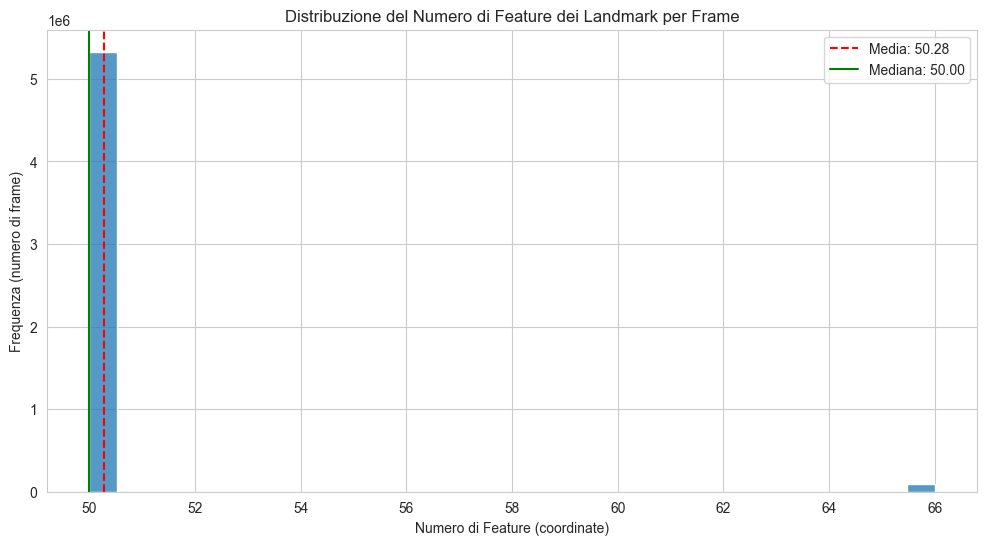


Conteggi dei valori più comuni per 'num_features':
num_features
50    5327860
66      95536
Name: count, dtype: int64


In [9]:
if feature_counts:
    # Creazione di un DataFrame per l'analisi
    df_features = pd.DataFrame(feature_counts, columns=["num_features"])

    # Calcolo delle statistiche descrittive
    stats = df_features["num_features"].describe(
        percentiles=[0.25, 0.5, 0.75, 0.90, 0.95, 0.99]
    )
    print("Statistiche sul numero di feature per frame:")
    print(stats)

    # Visualizzazione della distribuzione
    plt.figure(figsize=(12, 6))
    sns.histplot(df_features["num_features"], bins=30, kde=False)
    plt.title("Distribuzione del Numero di Feature dei Landmark per Frame")
    plt.xlabel("Numero di Feature (coordinate)")
    plt.ylabel("Frequenza (numero di frame)")

    # Aggiungi linee verticali per media e mediana
    plt.axvline(
        stats["mean"], color="red", linestyle="--", label=f"Media: {stats['mean']:.2f}"
    )
    plt.axvline(
        stats["50%"], color="green", linestyle="-", label=f"Mediana: {stats['50%']:.2f}"
    )
    plt.legend()
    plt.show()

    # Stampa i conteggi dei valori unici più comuni
    print("\nConteggi dei valori più comuni per 'num_features':")
    print(df_features["num_features"].value_counts().head(10))
else:
    print("Nessun dato sui landmark trovato. Impossibile eseguire l'analisi.")

## 5. Conclusioni

Sulla base delle statistiche e del grafico, possiamo osservare quale sia il numero di feature più comune.

- Se un valore è nettamente dominante (es. il 99% dei frame ha 66 feature), potremmo decidere di usarlo come `num_features` e considerare gli altri come outlier da troncare o riempire con padding.
- Se la distribuzione è più varia, potremmo scegliere un percentile alto (es. il 95°) per preservare la maggior parte dei dati senza essere eccessivamente influenzati da pochi frame con un numero anomalo di landmark.

Questa analisi ci fornisce una base solida per la nostra scelta.
